In [1]:
import torch 
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from tensor_edit import TensorEdit
from simplify_linear import SimplifyLinear
import utils


utils.set_seed(42)

In [2]:
# Convolutional neural network (two convolutional layers)
class ConvNet(nn.Module):
    def __init__(self, num_classes=10):
        super(ConvNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.activation = nn.ReLU()
        self.fc1 = SimplifyLinear(7*7*32, 7*7*32, True, False, False)
        self.fc2 = SimplifyLinear(7*7*32, num_classes, False, True, False)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.activation(self.fc1(out))
        out = self.fc2(out)
        return out

In [3]:
# Check Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Define Hyper parameters
num_classes = 10
model = ConvNet(num_classes).to(device)
n_start_params = sum(p.numel() for p in model.parameters())

batch_size = 100
num_epochs = 250
fig = None
filenames = []
train_accuracies = []
train_losses = []

In [4]:
# Load MNIST dataset
train_dataset = torchvision.datasets.MNIST(root='../../data/',
                                           train=True, 
                                           transform=transforms.ToTensor(),
                                           download=True)

test_dataset = torchvision.datasets.MNIST(root='../../data/',
                                          train=False, 
                                          transform=transforms.ToTensor())

# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size, 
                                          shuffle=False)
# Loss and optimizer
lr = 1e-3
lossFun = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

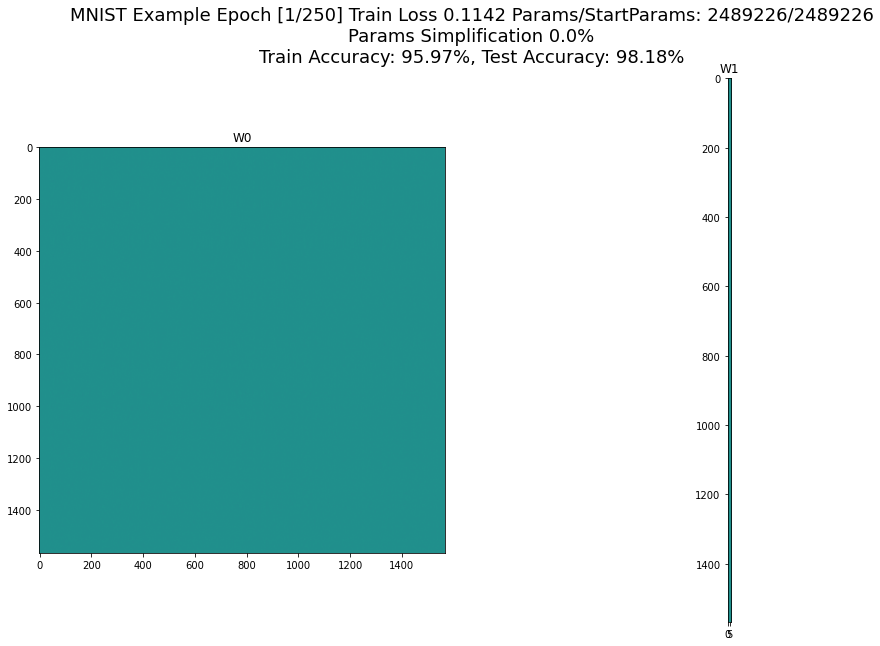

MNIST Example Epoch [1/250] Train Loss 0.1142 Params/StartParams: 2489226/2489226 Params Simplification 0.0% Train Accuracy: 95.97%, Test Accuracy: 98.18%


KeyboardInterrupt: 

<Figure size 1152x720 with 0 Axes>

In [5]:
%matplotlib inline

# weights figure
fig = plt.figure(figsize=(16, 10), facecolor='white')
# select the layers that can be simplified
simplify_layers = [module for module in model.modules() if isinstance(module, SimplifyLinear)]
te = TensorEdit(simplify_layers)

for epoch in range(num_epochs):
    total_loss = 0
    samples = 0
    correct = 0

    model.train()
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        loss = lossFun(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs.data, 1)
        samples += labels.size(0)
        correct += (predicted == labels).sum().item()

        # the force pulling down the weights in the range [-r_value; r_value] to zero
        #te.weights_drain(p_drain=0.005, r_value=0.45, condition=epoch!=0 and epoch%5==0)
        # the following decay avoids getting stuck in the simplification process.
        #te.weights_decay(p_decay=0.01, decay_rate=5e-3, condition=epoch!=0 and epoch%2==0)
        
    # remove weights if all values ​​in a row or column are less than the specified value
    #if te.weights_remove(p_remove=1, less_value=0.05, max_removal=0.1, min_size=20, verbose=True):
        # re-instantiate the optimizer with the new model if I have deleted any rows or columns
        #optimizer = torch.optim.Adam(model.parameters(), lr = lr)

    # train loss, accuracy, number of parameters
    train_accuracy = 100 * correct / samples
    train_loss = total_loss / len(train_loader)
    train_accuracies.append(train_accuracy)
    train_losses.append(train_loss)
    n_params = sum(p.numel() for p in model.parameters())
    simplification = (1 - n_params / n_start_params) * 100

    # test the model
    model.eval()
    test_accuracy = 0
    with torch.no_grad():
        correct = 0
        test_samples = 0
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            test_samples += labels.size(0)
            correct += (predicted == labels).sum().item()
        test_accuracy = 100 * correct / test_samples

    # select the weight matrices transposing them for a better visualization
    weights = [w.weight.data.T for w in simplify_layers]
    title1 = "MNIST Example Epoch [{}/{}] Train Loss {:.4f} Params/StartParams: {}/{}"\
                .format(epoch+1, num_epochs, loss.item(), n_params, n_start_params)
    title2 = "Params Simplification {:.1f}%"\
                .format(simplification)
    title3 = "Train Accuracy: {:.2f}%, Test Accuracy: {:.2f}%"\
                .format(train_accuracy, test_accuracy)
    utils.plot_weights(fig, weights, '\n'.join((title1, title2, title3)))
    
    # create a file name, append it to the filenames list
    filename = f'frame_{epoch}.png'
    filenames.append(filename)
    # and save the figure
    fig.savefig(filename, facecolor=fig.get_facecolor())
    plt.clf()

    print(' '.join((title1, title2, title3)))

    if simplification > 95.0 and test_accuracy > 98.0:
        break

In [ ]:
# build a gif by composing the frames
utils.images_to_gif(filenames, 'mnist_conv_simplify_weights_plot.gif', tail=100)

# create a mjpg video
utils.images_to_avi(filenames, 'mnist_conv_simplify_weights_plot.avi')

# Remove frame files
import os
for filename in set(filenames):
    os.remove(filename)